In [1]:
import requests
import json
import re
from IPython.display import Image

## Workflow Overview

This notebook uses the **Target.com API Endpoint** to extract product-level data. The full pipeline includes the following steps:

1. **Select Products and Cities**  
   - Identify products representative of a typical grocery basket.  
   - Choose the top 30 major U.S. cities.
     
2. **Extract Product Data from Target.com**  
   - Query Target.com for each selected product and corresponding `store_id`.  
   - Each `store_id` maps to a specific city (e.g., LA Sawtelle with `store_id = 3231` represents Los Angeles).

3. **Combine and Upload Data**  
   - Concatenate all product-level data into a single DataFrame.  
   - Save as a `.csv` file and upload to a **Google Cloud Storage (GCS)** bucket.

4. **Load to BigQuery**  
   - Load the `.csv` as a table called `product_fact` in **BigQuery**.

5. **Build Looker Dashboard**  
   - Create SQL views in BigQuery 
   - Connect the views as a data source for the **Looker dashboard**.
   - link: https://lookerstudio.google.com/reporting/4d7774ab-9339-4f63-a290-0dadf317a63f 

6. **Maintain and Refresh Data**  
   - Use a separate notebook to refresh the dataset and update the `product_fact` table on a regular basis.

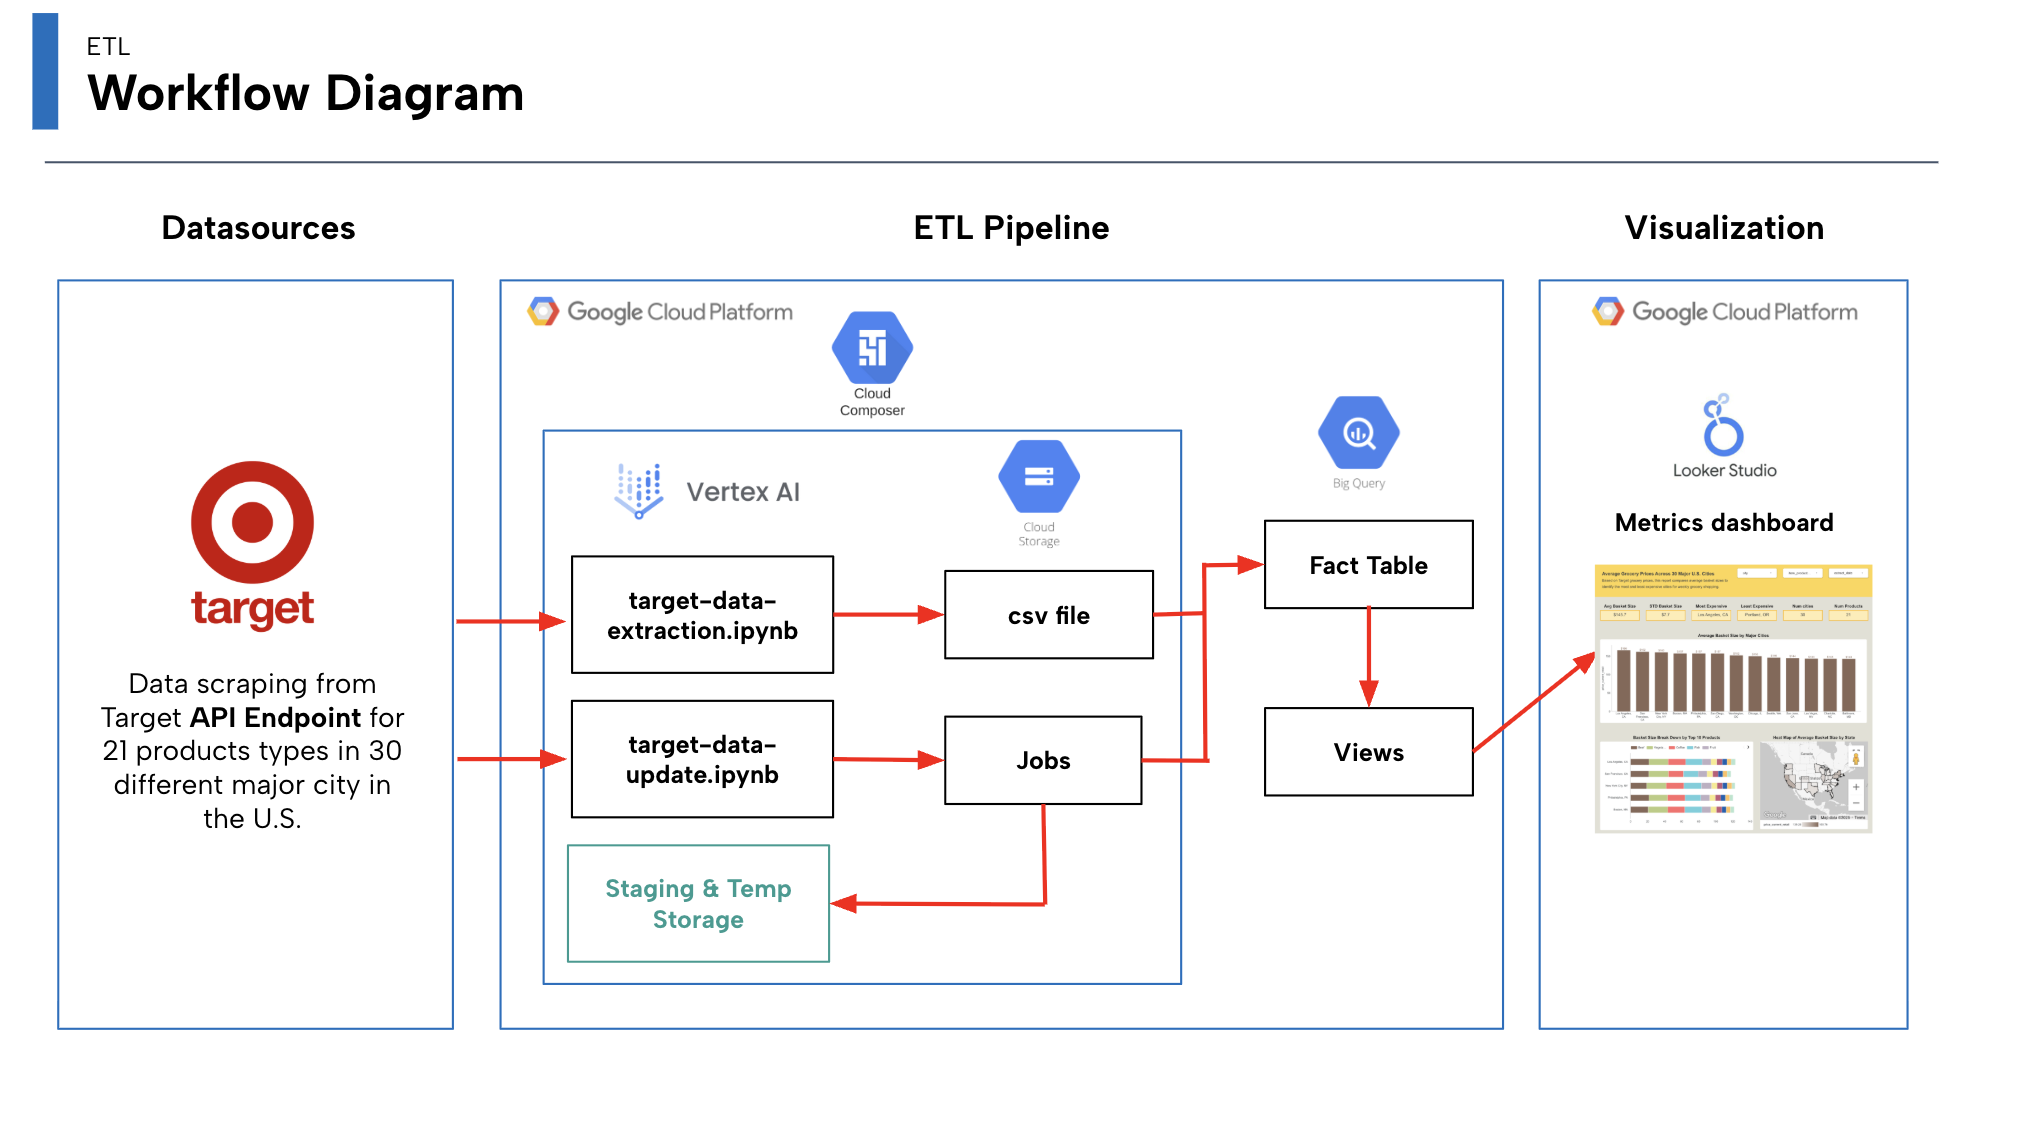

In [5]:
Image("workflow_etl.png", width=1000, height=300)

## Data Extraction

In [2]:
import requests
import pandas as pd
from pandas import json_normalize

headers = {
    "User-Agent": "Mozilla/5.0"
}

tcins = [
         "14713534", # egg
         "79858156", # shredded green
         "54555623", # spinach 
         "54556735", # baby carrots
         "82667380", # roma tomatoes
         "81957708", # hass avocado
         "77788700", # onions
         "14917318", # garlic
         "78784283", # sweet potatoes
         "77775602", # potatoes
         "85759852", # bananas
         "54579488" # apples
]

store_zip_map = {
    "3231": "90037",  # Los Angeles, CA
    "2799": "60657",  # Chicago, IL
    "3412": "10001",  # New York City, NY
    "1375": "55403",  # Minneapolis, MN
    "1975": "77042",  # Houston, TX
    "1141": "85016",  # Phoenix, AZ
    "3206": "19107",  # Philadelphia, PA
    "2465": "92110",  # San Diego, CA
    "1784": "75204",  # Dallas, TX
    "324":  "95128",  # San Jose, CA
    "1542": "78704",  # Austin, TX
    "1300": "32246",  # Jacksonville, FL
    "1072": "43219",  # Columbus, OH
    "2080": "28273",  # Charlotte, NC
    "1789": "46227",  # Indianapolis, IN
    "2786": "98101",  # Seattle, WA
    "2225": "80202",  # Denver, CO
    "2259": "20001",  # Washington, DC
    "771": "78224", # San Antonio, TX
    "2766": "94103", # San Francisco, CA
    "43": "73112", # Oklahoma City, OK
    "146": "37205", # Nashville, TN
    "3368": "02114", # Boston, MA
    "265": "89119", # Las Vegas, NV
    "279": "48126", # Detroit, MI
    "2068": "47129", # Louisville, KY
    "1419": "97232", # Portland, OR
    "2845": "21224", # Baltimore, MD
    "223": "53212", # Milwaukee, WI
    "1964": "30309" # Atlanta, GA  
}

all_flat_data = []

for store_id, zip_code in store_zip_map.items():
    tcin_param = ",".join(tcins)

    api_url = (
        f"https://redsky.target.com/redsky_aggregations/v1/web/product_summary_with_fulfillment_v1"
        f"?key=9f36aeafbe60771e321a7cc95a78140772ab3e96"
        f"&tcins={tcin_param}"
        f"&store_id={store_id}"
        f"&zip={zip_code}"
        f"&paid_membership=false"
        f"&base_membership=false"
        f"&card_membership=false"
        f"&required_store_id={store_id}"
        f"&channel=WEB"
    )

    print(f"Fetching store {store_id} (ZIP: {zip_code})...")
    try:
        resp = requests.get(api_url, headers=headers)
        data = resp.json()

        products = data.get("data", {}).get("product_summaries", [])

        for product in products:
            flat_product = json_normalize(product, sep='_')  # flatten all nested fields
            flat_product['store_id'] = store_id
            flat_product['zip_code'] = zip_code
            all_flat_data.append(flat_product)

    except Exception as e:
        print(f"Error fetching store {store_id}: {e}")

# Combine all records
produce_df = pd.concat(all_flat_data, ignore_index=True)
produce_df.head()

# Optional: Save as CSV or Excel
# df_flat.to_csv("target_flat_products.csv", index=False)

Fetching store 3231 (ZIP: 90037)...
Fetching store 2799 (ZIP: 60657)...
Fetching store 3412 (ZIP: 10001)...
Fetching store 1375 (ZIP: 55403)...
Fetching store 1975 (ZIP: 77042)...
Fetching store 1141 (ZIP: 85016)...
Fetching store 3206 (ZIP: 19107)...
Fetching store 2465 (ZIP: 92110)...
Fetching store 1784 (ZIP: 75204)...
Fetching store 324 (ZIP: 95128)...
Fetching store 1542 (ZIP: 78704)...
Fetching store 1300 (ZIP: 32246)...
Fetching store 1072 (ZIP: 43219)...
Fetching store 2080 (ZIP: 28273)...
Fetching store 1789 (ZIP: 46227)...
Fetching store 2786 (ZIP: 98101)...
Fetching store 2225 (ZIP: 80202)...
Fetching store 2259 (ZIP: 20001)...
Fetching store 771 (ZIP: 78224)...
Fetching store 2766 (ZIP: 94103)...
Fetching store 43 (ZIP: 73112)...
Fetching store 146 (ZIP: 37205)...
Fetching store 3368 (ZIP: 02114)...
Fetching store 265 (ZIP: 89119)...
Fetching store 279 (ZIP: 48126)...
Fetching store 2068 (ZIP: 47129)...
Fetching store 1419 (ZIP: 97232)...
Fetching store 2845 (ZIP: 21224)...

,__typename,tcin,desirability_cues,promotions,item_is_limited_time_offer,item_relationship_type_code,item_product_classification_item_type_name,item_product_classification_item_type_type,item_product_description_title,item_enrichment_buy_url,...,parent_item_is_limited_time_offer,parent_item_relationship_type_code,parent_item_product_classification_item_type_name,parent_item_product_classification_item_type_type,parent_item_product_description_title,parent_item_enrichment_buy_url,parent_item_merchandise_classification_class_id,parent_item_merchandise_classification_department_id,price_formatted_comparison_price,price_formatted_comparison_price_type
0,ProductSummary,14713534,"[{'code': 'bestseller', 'display': 'Bestseller...",[],False,SA,Eggs,290136,Grade A Large Eggs - 12ct - Good &#38; Gather&...,https://www.target.com/p/grade-a-large-eggs-12...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ProductSummary,79858156,NaN,[],False,SA,Vegetables,432323,Shredded Green Leaf Lettuce - 4.5oz - Good &#3...,https://www.target.com/p/shredded-green-leaf-l...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ProductSummary,54555623,NaN,[],False,SA,Vegetables,432323,Steam-in-Bag Spinach - 9oz - Good &#38; Gather...,https://www.target.com/p/steam-in-bag-spinach-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ProductSummary,54556735,NaN,[],False,VC,Vegetables,432323,Baby-Cut Carrots - 1lb - Good &#38; Gather&#8482;,https://www.target.com/p/baby-cut-carrots-1lb-...,...,False,VAP,Vegetables,432323,Baby-Cut Carrots - Good & Gather™,https://www.target.com/p/baby-cut-carrots-good...,15.0,211.0,NaN,NaN
4,ProductSummary,82667380,NaN,[],False,SA,Vegetables,432323,Roma Tomatoes - 16oz - Good &#38; Gather&#8482...,https://www.target.com/p/roma-tomatoes-16oz-go...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
import requests
import pandas as pd
from pandas import json_normalize

headers = {
    "User-Agent": "Mozilla/5.0"
}

tcins = [
         "81857166", # tofu
         "52205815", # chicken breast
         "84991367", # chicken thigh
         "13287606", # grounded beef
         "54640782", # steak
         "80114702", # frozen salmon
         "13573121", # canned tuna
         "13292010" # peanut butter 
]

store_zip_map = {
    "3231": "90037",  # Los Angeles, CA
    "2799": "60657",  # Chicago, IL
    "3412": "10001",  # New York City, NY
    "1375": "55403",  # Minneapolis, MN
    "1975": "77042",  # Houston, TX
    "1141": "85016",  # Phoenix, AZ
    "3206": "19107",  # Philadelphia, PA
    "2465": "92110",  # San Diego, CA
    "1784": "75204",  # Dallas, TX
    "324":  "95128",  # San Jose, CA
    "1542": "78704",  # Austin, TX
    "1300": "32246",  # Jacksonville, FL
    "1072": "43219",  # Columbus, OH
    "2080": "28273",  # Charlotte, NC
    "1789": "46227",  # Indianapolis, IN
    "2786": "98101",  # Seattle, WA
    "2225": "80202",  # Denver, CO
    "2259": "20001",  # Washington, DC
    "771": "78224", # San Antonio, TX
    "2766": "94103", # San Francisco, CA
    "43": "73112", # Oklahoma City, OK
    "146": "37205", # Nashville, TN
    "3368": "02114", # Boston, MA
    "265": "89119", # Las Vegas, NV
    "279": "48126", # Detroit, MI
    "2068": "47129", # Louisville, KY
    "1419": "97232", # Portland, OR
    "2845": "21224", # Baltimore, MD
    "223": "53212", # Milwaukee, WI
    "1964": "30309" # Atlanta, GA  
}

all_flat_data = []

for store_id, zip_code in store_zip_map.items():
    tcin_param = ",".join(tcins)

    api_url = (
        f"https://redsky.target.com/redsky_aggregations/v1/web/product_summary_with_fulfillment_v1"
        f"?key=9f36aeafbe60771e321a7cc95a78140772ab3e96"
        f"&tcins={tcin_param}"
        f"&store_id={store_id}"
        f"&zip={zip_code}"
        f"&paid_membership=false"
        f"&base_membership=false"
        f"&card_membership=false"
        f"&required_store_id={store_id}"
        f"&channel=WEB"
    )

    print(f"Fetching store {store_id} (ZIP: {zip_code})...")
    try:
        resp = requests.get(api_url, headers=headers)
        data = resp.json()

        products = data.get("data", {}).get("product_summaries", [])

        for product in products:
            flat_product = json_normalize(product, sep='_')  # flatten all nested fields
            flat_product['store_id'] = store_id
            flat_product['zip_code'] = zip_code
            all_flat_data.append(flat_product)

    except Exception as e:
        print(f"Error fetching store {store_id}: {e}")

# Combine all records
protien_df = pd.concat(all_flat_data, ignore_index=True)
protien_df.head()

# Optional: Save as CSV or Excel
# df_flat.to_csv("target_flat_products.csv", index=False)

Fetching store 3231 (ZIP: 90037)...
Fetching store 2799 (ZIP: 60657)...
Fetching store 3412 (ZIP: 10001)...
Fetching store 1375 (ZIP: 55403)...
Fetching store 1975 (ZIP: 77042)...
Fetching store 1141 (ZIP: 85016)...
Fetching store 3206 (ZIP: 19107)...
Fetching store 2465 (ZIP: 92110)...
Fetching store 1784 (ZIP: 75204)...
Fetching store 324 (ZIP: 95128)...
Fetching store 1542 (ZIP: 78704)...
Fetching store 1300 (ZIP: 32246)...
Fetching store 1072 (ZIP: 43219)...
Fetching store 2080 (ZIP: 28273)...
Fetching store 1789 (ZIP: 46227)...
Fetching store 2786 (ZIP: 98101)...
Fetching store 2225 (ZIP: 80202)...
Fetching store 2259 (ZIP: 20001)...
Fetching store 771 (ZIP: 78224)...
Fetching store 2766 (ZIP: 94103)...
Fetching store 43 (ZIP: 73112)...
Fetching store 146 (ZIP: 37205)...
Fetching store 3368 (ZIP: 02114)...
Fetching store 265 (ZIP: 89119)...
Fetching store 279 (ZIP: 48126)...
Fetching store 2068 (ZIP: 47129)...
Fetching store 1419 (ZIP: 97232)...
Fetching store 2845 (ZIP: 21224)...

,__typename,tcin,desirability_cues,promotions,store_positions,item_is_limited_time_offer,item_relationship_type_code,item_product_classification_item_type_name,item_product_classification_item_type_type,item_product_description_title,...,fulfillment_shipping_options_availability_status,fulfillment_shipping_options_loyalty_availability_status,fulfillment_shipping_options_services,fulfillment_store_options,store_id,zip_code,price_formatted_current_price_suffix,price_formatted_max_item_price,price_formatted_comparison_price,price_formatted_comparison_price_type
0,ProductSummary,81857166,"[{'code': 'bestseller', 'display': 'Bestseller...",[],"[{'block': 'B', 'aisle': 10, 'floor': '01'}]",False,SA,Vegetable Proteins,435709,Organic Extra-Firm Gluten Free Plant Based Tof...,...,OUT_OF_STOCK,OUT_OF_STOCK,[],"[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,NaN,NaN,NaN,NaN
1,ProductSummary,52205815,NaN,[],"[{'block': 'B', 'aisle': 17, 'floor': '01'}]",False,SA,Chicken,435802,Boneless Skinless Chicken Breast - 1.5-3.2lbs ...,...,OUT_OF_STOCK,OUT_OF_STOCK,[],"[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,max price,$12.13,NaN,NaN
2,ProductSummary,84991367,NaN,[],"[{'block': 'B', 'aisle': 17, 'floor': '01'}]",NaN,SA,Chicken,435802,Foster Farms NAE Chicken Thighs - 1.4-2.2lbs -...,...,OUT_OF_STOCK,OUT_OF_STOCK,[],"[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,max price,$6.14,NaN,NaN
3,ProductSummary,13287606,NaN,[],"[{'block': 'B', 'aisle': 17, 'floor': '01'}, {...",False,SA,Beef,435801,All Natural 80/20 Ground Beef - 1lb - Good &#3...,...,OUT_OF_STOCK,OUT_OF_STOCK,[],"[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,NaN,NaN,NaN,NaN
4,ProductSummary,54640782,NaN,[],NaN,False,SA,Beef,435801,USDA Choice Angus Petite Sirloin Steak - 0.60-...,...,OUT_OF_STOCK,OUT_OF_STOCK,[],"[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,max price,$14.83,NaN,NaN


In [4]:
import requests
import pandas as pd
from pandas import json_normalize

headers = {
    "User-Agent": "Mozilla/5.0"
}

tcins = [
         "12935871", # whole wheat bread
         "54604313", # jasmine rice
         "13156094", # pasta
         "89969887", # oat meal
         "89089937", # cereal
         "13276128", # 2% milk
         "77594471", # plant-based milk
         "13173297", # yogurt
         "54337113", # cheese
         "54445965" # butter 
]

store_zip_map = {
    "3231": "90037",  # Los Angeles, CA
    "2799": "60657",  # Chicago, IL
    "3412": "10001",  # New York City, NY
    "1375": "55403",  # Minneapolis, MN
    "1975": "77042",  # Houston, TX
    "1141": "85016",  # Phoenix, AZ
    "3206": "19107",  # Philadelphia, PA
    "2465": "92110",  # San Diego, CA
    "1784": "75204",  # Dallas, TX
    "324":  "95128",  # San Jose, CA
    "1542": "78704",  # Austin, TX
    "1300": "32246",  # Jacksonville, FL
    "1072": "43219",  # Columbus, OH
    "2080": "28273",  # Charlotte, NC
    "1789": "46227",  # Indianapolis, IN
    "2786": "98101",  # Seattle, WA
    "2225": "80202",  # Denver, CO
    "2259": "20001",  # Washington, DC
    "771": "78224", # San Antonio, TX
    "2766": "94103", # San Francisco, CA
    "43": "73112", # Oklahoma City, OK
    "146": "37205", # Nashville, TN
    "3368": "02114", # Boston, MA
    "265": "89119", # Las Vegas, NV
    "279": "48126", # Detroit, MI
    "2068": "47129", # Louisville, KY
    "1419": "97232", # Portland, OR
    "2845": "21224", # Baltimore, MD
    "223": "53212", # Milwaukee, WI
    "1964": "30309" # Atlanta, GA  
}

all_flat_data = []

for store_id, zip_code in store_zip_map.items():
    tcin_param = ",".join(tcins)

    api_url = (
        f"https://redsky.target.com/redsky_aggregations/v1/web/product_summary_with_fulfillment_v1"
        f"?key=9f36aeafbe60771e321a7cc95a78140772ab3e96"
        f"&tcins={tcin_param}"
        f"&store_id={store_id}"
        f"&zip={zip_code}"
        f"&paid_membership=false"
        f"&base_membership=false"
        f"&card_membership=false"
        f"&required_store_id={store_id}"
        f"&channel=WEB"
    )

    print(f"Fetching store {store_id} (ZIP: {zip_code})...")
    try:
        resp = requests.get(api_url, headers=headers)
        data = resp.json()

        products = data.get("data", {}).get("product_summaries", [])

        for product in products:
            flat_product = json_normalize(product, sep='_')  # flatten all nested fields
            flat_product['store_id'] = store_id
            flat_product['zip_code'] = zip_code
            all_flat_data.append(flat_product)

    except Exception as e:
        print(f"Error fetching store {store_id}: {e}")

# Combine all records
grain_df = pd.concat(all_flat_data, ignore_index=True)
grain_df.head()

# Optional: Save as CSV or Excel
# df_flat.to_csv("target_flat_products.csv", index=False)

Fetching store 3231 (ZIP: 90037)...
Fetching store 2799 (ZIP: 60657)...
Fetching store 3412 (ZIP: 10001)...
Fetching store 1375 (ZIP: 55403)...
Fetching store 1975 (ZIP: 77042)...
Fetching store 1141 (ZIP: 85016)...
Fetching store 3206 (ZIP: 19107)...
Fetching store 2465 (ZIP: 92110)...
Fetching store 1784 (ZIP: 75204)...
Fetching store 324 (ZIP: 95128)...
Fetching store 1542 (ZIP: 78704)...
Fetching store 1300 (ZIP: 32246)...
Fetching store 1072 (ZIP: 43219)...
Fetching store 2080 (ZIP: 28273)...
Fetching store 1789 (ZIP: 46227)...
Fetching store 2786 (ZIP: 98101)...
Fetching store 2225 (ZIP: 80202)...
Fetching store 2259 (ZIP: 20001)...
Fetching store 771 (ZIP: 78224)...
Fetching store 2766 (ZIP: 94103)...
Fetching store 43 (ZIP: 73112)...
Fetching store 146 (ZIP: 37205)...
Fetching store 3368 (ZIP: 02114)...
Fetching store 265 (ZIP: 89119)...
Fetching store 279 (ZIP: 48126)...
Fetching store 2068 (ZIP: 47129)...
Fetching store 1419 (ZIP: 97232)...
Fetching store 2845 (ZIP: 21224)...

,__typename,tcin,promotions,store_positions,item_is_limited_time_offer,item_relationship_type_code,item_product_classification_item_type_name,item_product_classification_item_type_type,item_product_description_title,item_enrichment_buy_url,...,parent_item_product_classification_item_type_name,parent_item_product_classification_item_type_type,parent_item_product_description_title,parent_item_enrichment_buy_url,parent_item_merchandise_classification_class_id,parent_item_merchandise_classification_department_id,item_is_variable_price_item,parent_item_is_variable_price_item,price_formatted_comparison_price,price_formatted_comparison_price_type
0,ProductSummary,12935871,[],"[{'block': 'B', 'aisle': 9, 'floor': '01'}, {'...",False,SA,Bread,437734,Oroweat 100% Whole Wheat Bread - 24oz,https://www.target.com/p/oroweat-100-whole-whe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ProductSummary,54604313,[],"[{'block': 'B', 'aisle': 8, 'floor': '01'}]",False,SA,Rice,433700,Jasmine Rice - 32oz - Good &#38; Gather&#8482;,https://www.target.com/p/jasmine-rice-2lbs-goo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ProductSummary,13156094,[],NaN,NaN,SA,Pasta,433515,Barilla Rotini Pasta - 16oz,https://www.target.com/p/barilla-rotini-pasta-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ProductSummary,79364883,[],"[{'block': 'B', 'aisle': 7, 'floor': '01'}]",False,VC,Porridges,433903,Old Fashioned Oats - 18oz - Good &#38; Gather&...,https://www.target.com/p/old-fashioned-oats-18...,...,Porridges,433903,Old Fashioned Oats - Good & Gather™,https://www.target.com/p/old-fashioned-oats-go...,14.0,231.0,NaN,NaN,NaN,NaN
4,ProductSummary,12924454,[],NaN,False,VC,Cold Cereals,433900,Cinnamon Toast Crunch Breakfast Cereal - 12oz ...,https://www.target.com/p/cinnamon-toast-crunch...,...,Cold Cereals,433900,Cinnamon Toast Crunch Breakfast Cereal,https://www.target.com/p/cinnamon-toast-crunch...,0.0,231.0,NaN,NaN,NaN,NaN


In [5]:
import requests
import pandas as pd
from pandas import json_normalize

headers = {
    "User-Agent": "Mozilla/5.0"
}

tcins = [
         "78376460", # canola oil
         "12954151", # grounded coffee
         "90332876", # instant coffee
         "94629839", # water 3 gallons
         "47085532" # chips
]

store_zip_map = {
    "3231": "90037",  # Los Angeles, CA
    "2799": "60657",  # Chicago, IL
    "3412": "10001",  # New York City, NY
    "1375": "55403",  # Minneapolis, MN
    "1975": "77042",  # Houston, TX
    "1141": "85016",  # Phoenix, AZ
    "3206": "19107",  # Philadelphia, PA
    "2465": "92110",  # San Diego, CA
    "1784": "75204",  # Dallas, TX
    "324":  "95128",  # San Jose, CA
    "1542": "78704",  # Austin, TX
    "1300": "32246",  # Jacksonville, FL
    "1072": "43219",  # Columbus, OH
    "2080": "28273",  # Charlotte, NC
    "1789": "46227",  # Indianapolis, IN
    "2786": "98101",  # Seattle, WA
    "2225": "80202",  # Denver, CO
    "2259": "20001",  # Washington, DC
    "771": "78224", # San Antonio, TX
    "2766": "94103", # San Francisco, CA
    "43": "73112", # Oklahoma City, OK
    "146": "37205", # Nashville, TN
    "3368": "02114", # Boston, MA
    "265": "89119", # Las Vegas, NV
    "279": "48126", # Detroit, MI
    "2068": "47129", # Louisville, KY
    "1419": "97232", # Portland, OR
    "2845": "21224", # Baltimore, MD
    "223": "53212", # Milwaukee, WI
    "1964": "30309" # Atlanta, GA  
}

all_flat_data = []

for store_id, zip_code in store_zip_map.items():
    tcin_param = ",".join(tcins)

    api_url = (
        f"https://redsky.target.com/redsky_aggregations/v1/web/product_summary_with_fulfillment_v1"
        f"?key=9f36aeafbe60771e321a7cc95a78140772ab3e96"
        f"&tcins={tcin_param}"
        f"&store_id={store_id}"
        f"&zip={zip_code}"
        f"&paid_membership=false"
        f"&base_membership=false"
        f"&card_membership=false"
        f"&required_store_id={store_id}"
        f"&channel=WEB"
    )

    print(f"Fetching store {store_id} (ZIP: {zip_code})...")
    try:
        resp = requests.get(api_url, headers=headers)
        data = resp.json()

        products = data.get("data", {}).get("product_summaries", [])

        for product in products:
            flat_product = json_normalize(product, sep='_')  # flatten all nested fields
            flat_product['store_id'] = store_id
            flat_product['zip_code'] = zip_code
            all_flat_data.append(flat_product)

    except Exception as e:
        print(f"Error fetching store {store_id}: {e}")

# Combine all records
pantry_df = pd.concat(all_flat_data, ignore_index=True)
pantry_df.head()

# Optional: Save as CSV or Excel
# df_flat.to_csv("target_flat_products.csv", index=False)

Fetching store 3231 (ZIP: 90037)...
Fetching store 2799 (ZIP: 60657)...
Fetching store 3412 (ZIP: 10001)...
Fetching store 1375 (ZIP: 55403)...
Fetching store 1975 (ZIP: 77042)...
Fetching store 1141 (ZIP: 85016)...
Fetching store 3206 (ZIP: 19107)...
Fetching store 2465 (ZIP: 92110)...
Fetching store 1784 (ZIP: 75204)...
Fetching store 324 (ZIP: 95128)...
Fetching store 1542 (ZIP: 78704)...
Fetching store 1300 (ZIP: 32246)...
Fetching store 1072 (ZIP: 43219)...
Fetching store 2080 (ZIP: 28273)...
Fetching store 1789 (ZIP: 46227)...
Fetching store 2786 (ZIP: 98101)...
Fetching store 2225 (ZIP: 80202)...
Fetching store 2259 (ZIP: 20001)...
Fetching store 771 (ZIP: 78224)...
Fetching store 2766 (ZIP: 94103)...
Fetching store 43 (ZIP: 73112)...
Fetching store 146 (ZIP: 37205)...
Fetching store 3368 (ZIP: 02114)...
Fetching store 265 (ZIP: 89119)...
Fetching store 279 (ZIP: 48126)...
Fetching store 2068 (ZIP: 47129)...
Fetching store 1419 (ZIP: 97232)...
Fetching store 2845 (ZIP: 21224)...

,__typename,tcin,desirability_cues,promotions,store_positions,item_is_limited_time_offer,item_relationship_type_code,item_product_classification_item_type_name,item_product_classification_item_type_type,item_product_description_title,...,fulfillment_is_out_of_stock_in_all_store_locations,fulfillment_sold_out,fulfillment_shipping_options_availability_status,fulfillment_shipping_options_loyalty_availability_status,fulfillment_shipping_options_services,fulfillment_store_options,store_id,zip_code,price_formatted_comparison_price,price_formatted_comparison_price_type
0,ProductSummary,78376460,"[{'code': 'highly_rated', 'display': 'Highly r...",[],"[{'block': 'B', 'aisle': 7, 'floor': '01'}]",False,VC,Cooking and Dipping Oils,90352576,Canola Oil - 48oz - Good &#38; Gather&#8482;,...,False,False,IN_STOCK,IN_STOCK,"[{'cutoff': '2025-06-24T19:00:00Z', 'shipping_...","[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,NaN,NaN
1,ProductSummary,12954151,NaN,[],"[{'block': 'B', 'aisle': 6, 'floor': '01'}]",False,VC,Coffee,430828,Starbucks Medium Roast Ground Coffee &#8212; P...,...,False,False,IN_STOCK,IN_STOCK,"[{'cutoff': '2025-06-24T19:00:00Z', 'shipping_...","[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,NaN,NaN
2,ProductSummary,90332876,NaN,[],NaN,NaN,SA,Coffee,430828,Nescafe Gold Blonde Espresso Roast - 3.5oz,...,False,False,IN_STOCK,IN_STOCK,"[{'cutoff': '2025-06-24T19:00:00Z', 'shipping_...","[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,NaN,NaN
3,ProductSummary,47085532,NaN,[],"[{'block': 'B', 'aisle': 26, 'floor': '01'}, {...",NaN,SA,"Chips, Puffs and Pretzels",425724,Lay's Classic Potato Chips - 8oz,...,False,False,IN_STOCK,IN_STOCK,"[{'cutoff': '2025-06-24T19:00:00Z', 'shipping_...","[{'search_response_store_type': 'PRIMARY', 'lo...",3231,90037,NaN,NaN
4,ProductSummary,78376460,"[{'code': 'highly_rated', 'display': 'Highly r...",[],"[{'block': 'L', 'aisle': 5, 'floor': '01'}]",False,VC,Cooking and Dipping Oils,90352576,Canola Oil - 48oz - Good &#38; Gather&#8482;,...,False,False,IN_STOCK,IN_STOCK,"[{'cutoff': '2025-06-23T23:00:00Z', 'shipping_...","[{'search_response_store_type': 'PRIMARY', 'lo...",2799,60657,NaN,NaN


In [6]:
def extract_fulfillment_info(row):
    options = row[0] if row else {}
    quantity = options.get('location_available_to_promise_quantity')
    location_name = options.get('store', {}).get('location_name')
    # You can customize which status to extract; here we take 'order_pickup'
    availability_status = options.get('order_pickup', {}).get('availability_status')
    return pd.Series([quantity, location_name, availability_status])

# Apply the function
produce_df[['location_available_to_promise_quantity', 'location_name', 'availability_status']] = produce_df['fulfillment_store_options'].apply(extract_fulfillment_info)
protien_df[['location_available_to_promise_quantity', 'location_name', 'availability_status']] = protien_df['fulfillment_store_options'].apply(extract_fulfillment_info)
grain_df[['location_available_to_promise_quantity', 'location_name', 'availability_status']] = grain_df['fulfillment_store_options'].apply(extract_fulfillment_info)
pantry_df[['location_available_to_promise_quantity', 'location_name', 'availability_status']] = pantry_df['fulfillment_store_options'].apply(extract_fulfillment_info)

In [7]:
target_data_all = pd.concat([produce_df, protien_df, grain_df, pantry_df], ignore_index=True)
target_data_all.shape

(1020, 50)

In [8]:
from datetime import date

target_data_all["extract_date"] = date.today()
target_data_all.head()

,__typename,tcin,desirability_cues,promotions,item_is_limited_time_offer,item_relationship_type_code,item_product_classification_item_type_name,item_product_classification_item_type_type,item_product_description_title,item_enrichment_buy_url,...,parent_item_merchandise_classification_department_id,price_formatted_comparison_price,price_formatted_comparison_price_type,location_available_to_promise_quantity,location_name,availability_status,price_formatted_current_price_suffix,price_formatted_max_item_price,parent_item_is_variable_price_item,extract_date
0,ProductSummary,14713534,"[{'code': 'bestseller', 'display': 'Bestseller...",[],False,SA,Eggs,290136,Grade A Large Eggs - 12ct - Good &#38; Gather&...,https://www.target.com/p/grade-a-large-eggs-12...,...,NaN,NaN,NaN,0.0,LA Sawtelle,UNAVAILABLE,NaN,NaN,NaN,2025-06-23
1,ProductSummary,79858156,NaN,[],False,SA,Vegetables,432323,Shredded Green Leaf Lettuce - 4.5oz - Good &#3...,https://www.target.com/p/shredded-green-leaf-l...,...,NaN,NaN,NaN,9.0,LA Sawtelle,IN_STOCK,NaN,NaN,NaN,2025-06-23
2,ProductSummary,54555623,NaN,[],False,SA,Vegetables,432323,Steam-in-Bag Spinach - 9oz - Good &#38; Gather...,https://www.target.com/p/steam-in-bag-spinach-...,...,NaN,NaN,NaN,7.0,LA Sawtelle,IN_STOCK,NaN,NaN,NaN,2025-06-23
3,ProductSummary,54556735,NaN,[],False,VC,Vegetables,432323,Baby-Cut Carrots - 1lb - Good &#38; Gather&#8482;,https://www.target.com/p/baby-cut-carrots-1lb-...,...,211.0,NaN,NaN,10.0,LA Sawtelle,IN_STOCK,NaN,NaN,NaN,2025-06-23
4,ProductSummary,82667380,NaN,[],False,SA,Vegetables,432323,Roma Tomatoes - 16oz - Good &#38; Gather&#8482...,https://www.target.com/p/roma-tomatoes-16oz-go...,...,NaN,NaN,NaN,0.0,LA Sawtelle,UNAVAILABLE,NaN,NaN,NaN,2025-06-23


In [11]:
target_data_all.columns

Index(['__typename', 'tcin', 'desirability_cues', 'promotions',
       'item_is_limited_time_offer', 'item_relationship_type_code',
       'item_product_classification_item_type_name',
       'item_product_classification_item_type_type',
       'item_product_description_title', 'item_enrichment_buy_url',
       'item_merchandise_classification_class_id',
       'item_merchandise_classification_department_id',
       'item_is_variable_price_item', 'free_shipping_enabled',
       'price_current_retail', 'price_display_was_now',
       'price_formatted_current_price', 'price_formatted_current_price_type',
       'price_formatted_unit_price', 'price_formatted_unit_price_suffix',
       'price_reg_retail', 'price_location_id', 'fulfillment_product_id',
       'fulfillment_is_out_of_stock_in_all_store_locations',
       'fulfillment_sold_out',
       'fulfillment_shipping_options_availability_status',
       'fulfillment_shipping_options_loyalty_availability_status',
       'fulfillment_ship

In [12]:
target_data_all.to_csv("target_products_0623.csv", index=False)

In [ ]:
# Save DataFrame to a CSV file (local to the notebook environment)
file_name = 'target-raw-data-0623.csv'
target_data_all.to_csv(file_name, index=False)
print(f"DataFrame saved locally as {file_name}")

In [ ]:
# Upload the CSV file to Google Cloud Storage

from google.cloud import storage

bucket_name = 'target-data-pipeline-bucket'
destination_blob_name = f'raw_data/{file_name}'

try:
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(file_name) # Uses the locally saved file
    print(f"File '{file_name}' uploaded to gs://{bucket_name}/{destination_blob_name}")
except Exception as e:
    print(f"Error uploading to GCS: {e}")
    

In [ ]:
from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client()

# Define dataset and table information
project_id = 'nth-rookery-463621-v8'  # Replace with your GCP project ID
dataset_id = 'target_data'  # Replace with your BigQuery dataset name
table_id = 'product-fact-v2'  # Choose a name for your BigQuery table
gcs_uri = f'gs://target-data-pipeline-bucket/raw_data/target-raw-data-0623.csv'  # Full GCS path to your CSV

job_config = bigquery.LoadJobConfig(
    skip_leading_rows=1,  # Still need to skip the header row
    source_format=bigquery.SourceFormat.CSV,
    autodetect=True,      # BigQuery will infer the schema
)

# 4. Load the data into BigQuery
table_ref = client.dataset(dataset_id, project=project_id).table(table_id)
load_job = client.load_table_from_uri(
    gcs_uri, table_ref, job_config=job_config
)

load_job.result() # Waits for the job to complete.
destination_table = client.get_table(table_ref)
print(f"Loaded {destination_table.num_rows} rows into {dataset_id}.{table_id}")

# Optional: Print the autodetected schema
print("\nAutodetected Schema:")
for field in destination_table.schema:
    print(f"  Field: {field.name}, Type: {field.field_type}, Mode: {field.mode}")